## GenPop Stress main figures & tables

This is a master script for the main figures in Python.

In [22]:
# Necessary Imports
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

### Figure 2D

In [2]:
fits = pd.read_csv("../../data/ds12w_fits_imp.csv")
# wide to long
fits_d = fits.drop(columns=['K_L_sd.x', 'K_L_sd.y', 'K_L_sd', 'K_S_sd.x','K_S_sd.y'])
fits_d.rename(columns={'K_S.x': 'K_S-1', 'K_S.y': 'K_S-2','K_L.x': 'K_L-1', 'K_L.y': 'K_L-2', 'K_L': 'K_L-3'}, inplace=True)
fits_l = pd.wide_to_long(fits_d, ['K_S','K_L'], i = 'subjid', j = 'session', sep = '-')

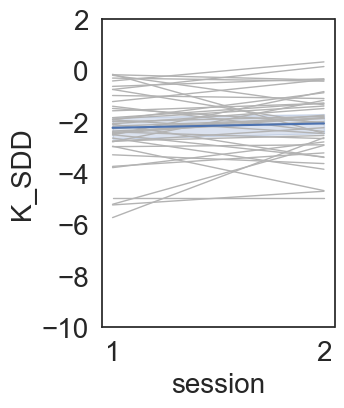

In [3]:
# left panel, SDD
fits_l["K_SDD"] = np.log(np.exp(fits_l["K_S"])/86400)
sns.set_theme(style="white")
font = {'size'   : 40}

plt.rc('font', **font)
fig, ax = plt.subplots()
fig.set_size_inches(3,4)
kss = sns.lineplot(
    data=fits_l, x="session", y="K_SDD", units='subjid', 
    color=".7", linewidth=1, estimator=None,
    )
kss.set_ylim(-10, 2)
kss.set_xticks([1, 2])
sns.lineplot(
    data=fits_l,
    x="session", y="K_SDD",
)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
#fig.savefig('../../figs/SDD.pdf', bbox_inches="tight")

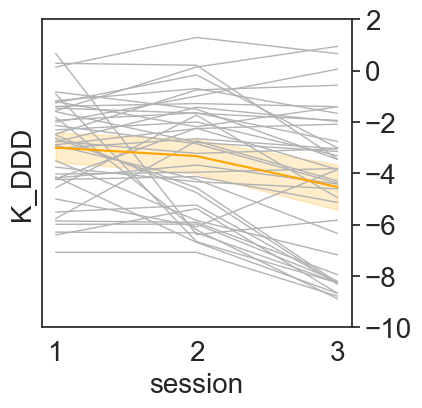

In [4]:
# right panel, SDD
fits_l["K_DDD"] = fits_l["K_L"]
sns.set_theme(style="white")
plt.rc('font', **font)
fig2, ax = plt.subplots()
fig2.set_size_inches(4,4)
kds = sns.lineplot(
    data=fits_l, x="session", y="K_DDD", units='subjid', 
    color=".7", linewidth=1, estimator=None,
    )
kds.set_ylim(-10, 2)
kds.set_xticks([1, 2, 3])
kd = sns.lineplot(
    data=fits_l,
    x="session", y="K_DDD", color='orange'
)
kd.yaxis.tick_right()
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
#fig2.savefig('../../figs/DDD.pdf', bbox_inches="tight")

### Figure 3C

In [5]:
stress = pd.read_csv("../../data/dfjstr.csv")
# wide to long
saliva = stress[['subjid','ls1','ls2','ls3']]
saliva_l = pd.wide_to_long(saliva, 'ls', i = 'subjid', j = 'session')
hair = stress[['subjid','lh1','lh2','lh3']]
hair_l = pd.wide_to_long(hair, 'lh', i = 'subjid', j = 'session')
saliva_l.rename(columns={'ls': 'l', }, inplace=True)
saliva_l['sample'] = 'saliva'
hair_l.rename(columns={'lh': 'l', }, inplace=True)
hair_l['sample'] = 'hair'
stress_l = pd.concat([saliva_l, hair_l])
stress_lm = stress_l.reset_index()

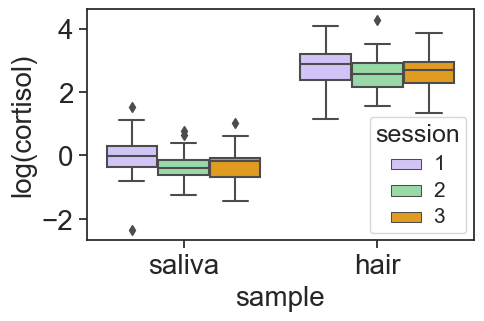

In [23]:
sns.set_theme(style="ticks", palette="pastel")
figstr, ax = plt.subplots()
figstr.set_size_inches(5,3)
# Draw a nested boxplot to show cortisol session/sample type
strs = sns.boxplot(hue="session", y="l",
            x="sample", palette=["m", "g", "orange"],
            data=stress_lm)
# for legend text
plt.setp(strs.get_legend().get_texts(), fontsize='15') 
# for legend title
plt.setp(strs.get_legend().get_title(), fontsize='18') 
strs.set(ylabel = "log(cortisol)")
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
#figstr.savefig('../../figs/cort.pdf', bbox_inches="tight")

In [7]:
# modeling imports
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.metrics import PredictionErrorDisplay
import shap
from matplotlib.ticker import FormatStrFormatter

### Table 1

In [8]:
# preprocessing
data = fits.merge(stress,on='subjid')
# between-subject
data_bs = data[['K_S.x','K_S.y','K_L.x','K_L.y','K_L','pss','bepsi','lcu','ls1','ls2','ls3','lh1','lh2','lh3']]
scaler = StandardScaler().set_output(transform="pandas")
# drop rows with missing values
data_bs.dropna(inplace=True)
scdata_bs = scaler.fit_transform(data_bs) 
# within-subject
data['K_Sd2'] = data['K_S.y']-data['K_S.x']
data['K_Ld2'] = data['K_L.y']-data['K_L.x']
data['K_Ld3'] = data['K_L']-data['K_L.x']
data['K_Ld32'] = data['K_L']-data['K_L.y']
data_ws = data[['K_Sd2','K_Ld2','K_Ld3','K_Ld32','lds2','lds3','lds32','ldh2','ldh3','ldh32']]
# drop rows with missing values
data_ws.dropna(inplace=True)
scdata_ws = scaler.fit_transform(data_ws) 

#### within-subject

In [9]:
X_ws = scdata_ws[scdata_ws.columns[-6:]]
Y_skws = scdata_ws[scdata_ws.columns[0]]
Y_d2kws = scdata_ws[scdata_ws.columns[1]]
Y_d3kws = scdata_ws[scdata_ws.columns[2]]
Y_d32kws = scdata_ws[scdata_ws.columns[3]]
print("Number of Datapoints:", X_ws.shape[0])
print("Number of Input Features:", X_ws.shape[1])

Number of Datapoints: 36
Number of Input Features: 6


In [10]:
scmod_skws_cv = RidgeCV(cv=5, alphas=[1e-3, 1e-2, 1e-1, 1]).fit(X_ws, Y_skws)
# Return the coefficient of determination of the prediction
scmod_skws_cv.score(X_ws, Y_skws) # 0.25

0.2514488510207433

In [14]:
y_pred_ws_p = scmod_skws_cv.predict(X_ws)

In [11]:
scmod_d2kws_cv = RidgeCV(cv=5, alphas=[1e-3, 1e-2, 1e-1, 1]).fit(X_ws, Y_d2kws)
# Return the coefficient of determination of the prediction
scmod_d2kws_cv.score(X_ws, Y_d2kws) # 0.13

0.1339106674954056

In [12]:
scmod_d3kws_cv = RidgeCV(cv=5, alphas=[1e-3, 1e-2, 1e-1, 1]).fit(X_ws, Y_d3kws)
# Return the coefficient of determination of the prediction
scmod_d3kws_cv.score(X_ws, Y_d3kws) # 0.06

0.05997043921134859

In [13]:
scmod_d32kws_cv = RidgeCV(cv=5, alphas=[1e-3, 1e-2, 1e-1, 1]).fit(X_ws, Y_d32kws)
# Return the coefficient of determination of the prediction
scmod_d32kws_cv.score(X_ws, Y_d32kws) # 0.10

0.10284509723207946

#### between-subject

In [20]:
X_bs = scdata_bs[scdata_bs.columns[-9:]]
Y_s1kbs = scdata_bs[scdata_bs.columns[0]]
Y_s2kbs = scdata_bs[scdata_bs.columns[1]]
Y_askbs = (scdata_bs[scdata_bs.columns[0]] + scdata_bs[scdata_bs.columns[1]])/2
Y_d1kbs = scdata_bs[scdata_bs.columns[2]]
Y_d2kbs = scdata_bs[scdata_bs.columns[3]]
Y_d3kbs = scdata_bs[scdata_bs.columns[4]]
print("Number of Datapoints:", X_bs.shape[0])
print("Number of Input Features:", X_bs.shape[1])

Number of Datapoints: 34
Number of Input Features: 9


In [21]:
scmod_s1kbs_cv = RidgeCV(cv=5, alphas=[1e-3, 1e-2, 1e-1, 1]).fit(X_bs, Y_s1kbs)
# Return the coefficient of determination of the prediction
scmod_s1kbs_cv.score(X_bs, Y_s1kbs) # 0.50

0.49771394628603194

In [22]:
scmod_s2kbs_cv = RidgeCV(cv=5, alphas=[1e-3, 1e-2, 1e-1, 1]).fit(X_bs, Y_s2kbs)
# Return the coefficient of determination of the prediction
scmod_s2kbs_cv.score(X_bs, Y_s2kbs) # 0.24

0.23856181527533526

In [33]:
# for figure 5
scmod_askbs_cv = RidgeCV(cv=5, alphas=[1e-3, 1e-2, 1e-1, 1]).fit(X_bs, Y_askbs)
# Return the coefficient of determination of the prediction
scmod_askbs_cv.score(X_bs, Y_askbs) # 0.38
y_pred_abs_p = scmod_askbs_cv.predict(X_bs)

In [24]:
scmod_d1kbs_cv = RidgeCV(cv=5, alphas=[1e-3, 1e-2, 1e-1, 1]).fit(X_bs, Y_d1kbs)
# Return the coefficient of determination of the prediction
scmod_d1kbs_cv.score(X_bs, Y_d1kbs) # 0.18

0.1820027807941923

In [25]:
scmod_d2kbs_cv = RidgeCV(cv=5, alphas=[1e-3, 1e-2, 1e-1, 1]).fit(X_bs, Y_d2kbs)
# Return the coefficient of determination of the prediction
scmod_d2kbs_cv.score(X_bs, Y_d2kbs) # 0.06

0.06066262250492893

In [26]:
scmod_d3kbs_cv = RidgeCV(cv=5, alphas=[1e-3, 1e-2, 1e-1, 1]).fit(X_bs, Y_d3kbs)
# Return the coefficient of determination of the prediction
scmod_d3kbs_cv.score(X_bs, Y_d3kbs) # 0.07

0.06663646376018895

### Figure 4A

In [29]:
r, p = sp.stats.pearsonr(x=scdata_ws[scdata_ws.columns[8]], y=scdata_ws[scdata_ws.columns[0]])
print(r,p)

0.3567261433142769 0.032708537106305516


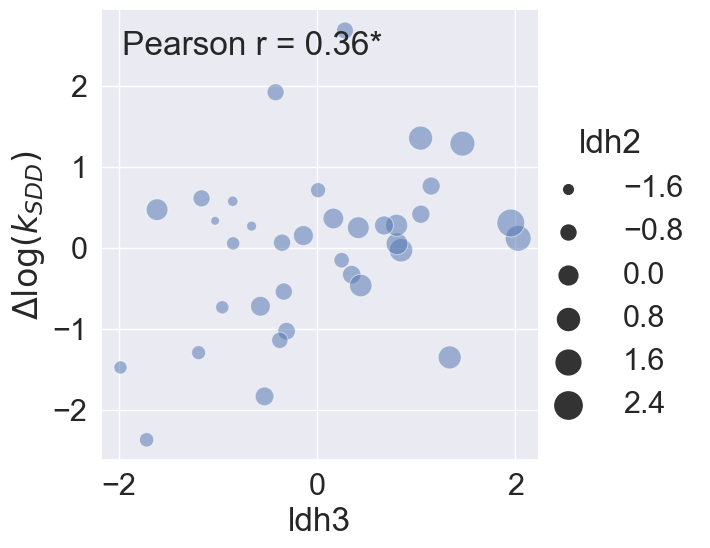

In [76]:
sns.set(font_scale=2)
#sns.set_theme(style="darkgrid")
#cmap = sns.cubehelix_palette(rot=.5, as_cmap=True)
#cmap = sns.diverging_palette(h_neg = 50, h_pos = 300, as_cmap=True)
cmap = 'seismic'
corp = sns.relplot(x="ldh3", y="K_Sd2", 
            #hue="lds32",
            size="ldh2",
            sizes=(40, 400), alpha=.5, palette=cmap,
            height=6, data=scdata_ws)
ax = plt.gca() # Get a matplotlib's axes instance
plt.text(.05, .9, "Pearson r = {:.2f}*".format(r), transform=ax.transAxes) #, fontsize='18'
plt.ylabel(r"$\Delta\log(k_{SDD})$")
#corp.legend(fontsize = 16)
#for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
#             ax.get_xticklabels() + ax.get_yticklabels()):
#    item.set_fontsize(16)
#corp.savefig('../../figs/corp.pdf', bbox_inches="tight")

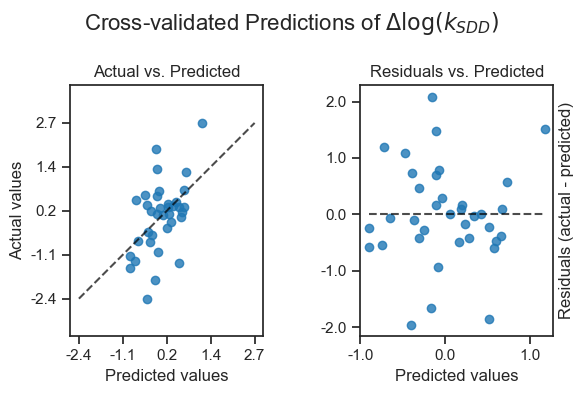

In [16]:
y = Y_skws
fig, axs = plt.subplots(ncols=2, figsize=(6, 4))
PredictionErrorDisplay.from_predictions(
    y,
    y_pred=y_pred_ws_p,
    kind="actual_vs_predicted",
    subsample=100,
    ax=axs[0],
    random_state=0,
)
axs[0].set_title("Actual vs. Predicted")
PredictionErrorDisplay.from_predictions(
    y,
    y_pred=y_pred_ws_p,
    kind="residual_vs_predicted",
    subsample=100,
    ax=axs[1],
    random_state=0,
)
axs[1].set_title("Residuals vs. Predicted")
axs[0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
axs[1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
axs[0].xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
axs[1].xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
axs[1].yaxis.set_label_position("right")
fig.suptitle("Cross-validated Predictions of "+r"$\Delta\log(k_{SDD})$", fontsize='16')
plt.tight_layout()
plt.subplots_adjust(wspace=0.5)
plt.show()
for item in ([axs[0].title, axs[1].title, axs[0].xaxis.label, axs[1].xaxis.label, axs[0].yaxis.label, axs[1].yaxis.label] +
             axs[0].get_xticklabels() + axs[1].get_xticklabels() + axs[0].get_yticklabels() + axs[1].get_yticklabels()):
    item.set_fontsize(14)
#fig.savefig("../../figs/wsb_new.pdf",dpi=700, bbox_inches = 'tight')

### Figure 4B

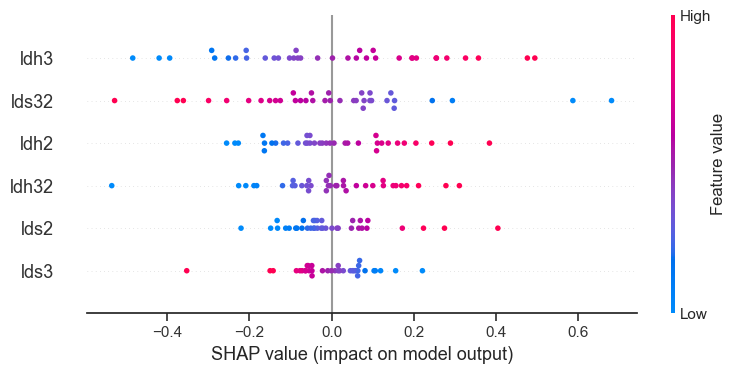

In [28]:
ws_explainer = shap.LinearExplainer(scmod_skws_cv,X_ws)
ws_shapCV = ws_explainer(X_ws)
ws_shap_valuesCV = ws_explainer.shap_values(X_ws)
shap.summary_plot(ws_shap_valuesCV, X_ws)
#plt.savefig("../../figs/wsSHAP.pdf",dpi=700)

### Figure 4C

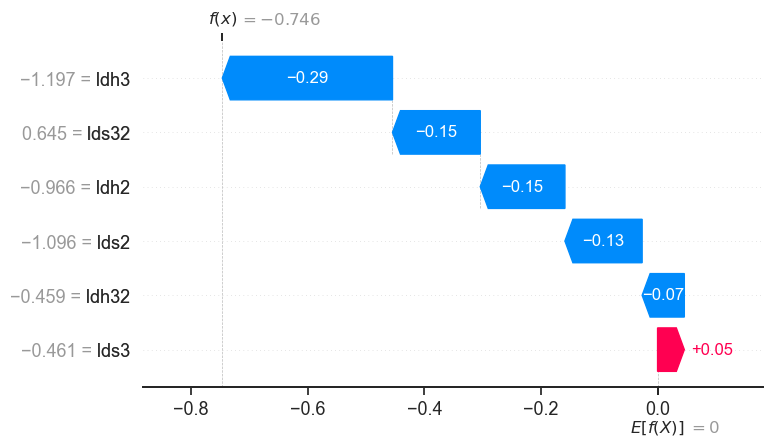

In [30]:
shap.plots.waterfall(ws_shapCV[34]) 
#plt.savefig("../../figs/wsSHAPl.pdf",dpi=700, bbox_inches = 'tight') 

### Figure 4D

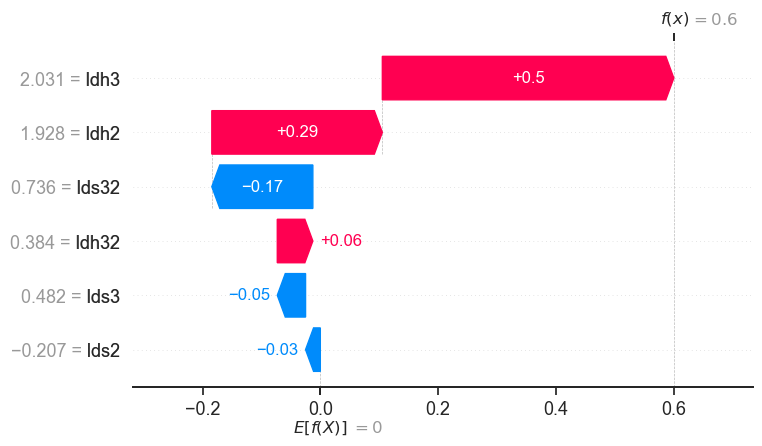

In [29]:
shap.plots.waterfall(ws_shapCV[4])
#plt.savefig("../../figs/wsSHAPh.pdf",dpi=700, bbox_inches = 'tight')

### Figure 5A

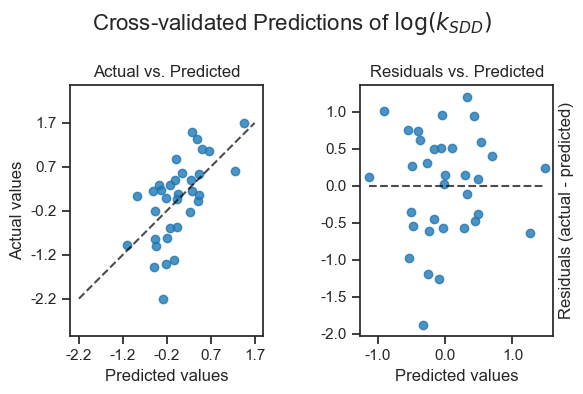

In [34]:
y = Y_askbs
fig, axs = plt.subplots(ncols=2, figsize=(6, 4))
PredictionErrorDisplay.from_predictions(
    y,
    y_pred=y_pred_abs_p,
    kind="actual_vs_predicted",
    subsample=100,
    ax=axs[0],
    random_state=0,
)
axs[0].set_title("Actual vs. Predicted")
PredictionErrorDisplay.from_predictions(
    y,
    y_pred=y_pred_abs_p,
    kind="residual_vs_predicted",
    subsample=100,
    ax=axs[1],
    random_state=0,
)
axs[1].set_title("Residuals vs. Predicted")
axs[0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
axs[1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
axs[0].xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
axs[1].xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
axs[1].yaxis.set_label_position("right")
fig.suptitle("Cross-validated Predictions of "+r"$\log(k_{SDD})$", fontsize='16')
plt.tight_layout()
plt.subplots_adjust(wspace=0.5)
plt.show()
for item in ([axs[0].title, axs[1].title, axs[0].xaxis.label, axs[1].xaxis.label, axs[0].yaxis.label, axs[1].yaxis.label] +
             axs[0].get_xticklabels() + axs[1].get_xticklabels() + axs[0].get_yticklabels() + axs[1].get_yticklabels()):
    item.set_fontsize(14)
#fig.savefig("../../figs/bsb_new.pdf",dpi=700, bbox_inches = 'tight')

### Figure 5B

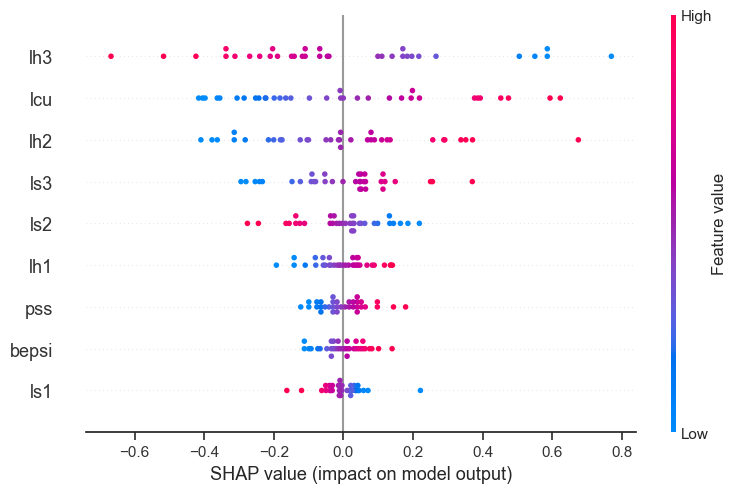

In [35]:
abs_explainer = shap.LinearExplainer(scmod_askbs_cv,X_bs)
abs_shap_valuesCV = abs_explainer.shap_values(X_bs)
shap.summary_plot(abs_shap_valuesCV, X_bs)
#plt.savefig("../../figs/bsSHAP.pdf",dpi=700, bbox_inches = 'tight') 

### Figure 5C

In [36]:
# creating new variable
data['incpatient'] = data['K_L']<(data['K_L.x']+data['K_L.y'])/2

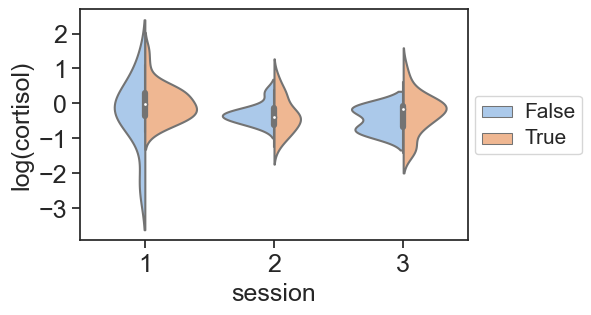

In [37]:
figsal, ax = plt.subplots()
figsal.set_size_inches(5,3)
saliva = data[['subjid','incpatient','ls1','ls2','ls3']]
saliva_l = pd.wide_to_long(saliva, 'ls', i = 'subjid', j = 'session')
saliva_lm = saliva_l.reset_index()
sal = sns.violinplot(data=saliva_lm, x="session", y="ls", hue="incpatient", split=True)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
sal.set(ylabel = "log(cortisol)")
# for legend text
plt.setp(sal.get_legend().get_texts(), fontsize='15') 
# for legend title
plt.setp(sal.get_legend().get_title(), fontsize='18') 
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(18)
#figsal.savefig('../../figs/sal.pdf', bbox_inches="tight")

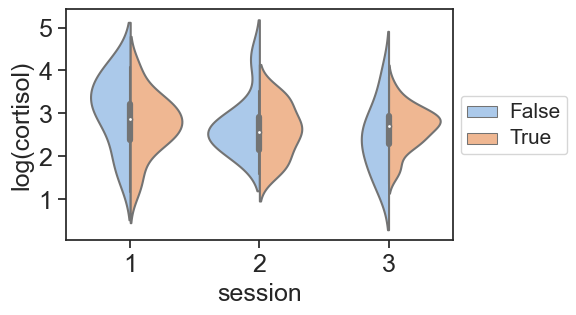

In [38]:
figha, ax = plt.subplots()
figha.set_size_inches(5,3)
hair = data[['subjid','incpatient','lh1','lh2','lh3']]
hair_l = pd.wide_to_long(hair, 'lh', i = 'subjid', j = 'session')
hair_lm = hair_l.reset_index()
ha = sns.violinplot(data=hair_lm, x="session", y="lh", hue="incpatient", split=True)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ha.set(ylabel = "log(cortisol)")
# for legend text
plt.setp(ha.get_legend().get_texts(), fontsize='15') 
# for legend title
plt.setp(ha.get_legend().get_title(), fontsize='18') 
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(18)
#figha.savefig('../../figs/hair.pdf', bbox_inches="tight")